data preprocess

In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

dataset_path = "Dataset/dataset_for_traffic_project_assignment/training_dataset.csv"

df = pd.read_csv(dataset_path, sep=";")


In [2]:
df.shape

(1921967, 11)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1921967 entries, 0 to 1921966
Data columns (total 11 columns):
 #   Column        Dtype  
---  ------        -----  
 0   DP_ID         int64  
 1   PORTAL        object 
 2   Date          int64  
 3   Time          object 
 4   Interval_1    int64  
 5   Interval_5    int64  
 6   Interval_15   int64  
 7   Interval_30   int64  
 8   Interval_60   int64  
 9   SPEED_MS_AVG  float64
 10  FLOW          float64
dtypes: float64(2), int64(7), object(2)
memory usage: 161.3+ MB


## 1.2 Data Preprocessing Steps

In [4]:
df_processed = df.copy()

if not pd.api.types.is_datetime64_any_dtype(df_processed['Date']):
    df_processed['Date'] = pd.to_datetime(df_processed['Date'].astype(str), format='%Y%m%d')

time_dt = pd.to_datetime(df_processed['Time'], format='%H:%M:%S')
df_processed['Day'] = df_processed['Date'].dt.day_name()
df_processed['Month'] = df_processed['Date'].dt.month_name()
df_processed['Hour'] = time_dt.dt.hour
df_processed['Minute'] = time_dt.dt.minute
df_processed['Minute_Of_Day'] = df_processed['Hour'] * 60 + df_processed['Minute']


In [5]:
day_mapping = {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7}
df_processed['Day_ID'] = df_processed['Day'].map(day_mapping)

month_mapping = {'June': 6, 'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12}
df_processed['Month_ID'] = df_processed['Month'].map(month_mapping)

df_processed['Is_Weekend'] = df_processed['Day_ID'].isin([6, 7]).astype(int)
df_processed['Is_Peak_Morning'] = df_processed['Minute_Of_Day'].between(7 * 60 + 30, 8 * 60 + 30).astype(int)
df_processed['Daily_Sin'] = np.sin(2 * np.pi * df_processed['Minute_Of_Day'] / 1440.0)
df_processed['Daily_Cos'] = np.cos(2 * np.pi * df_processed['Minute_Of_Day'] / 1440.0)


In [6]:
portal_numbers = df_processed['PORTAL'].astype(str).str.extract(r'(\d+[\.,]?\d*)', expand=False)
portal_numbers = portal_numbers.str.replace('[^0-9]', '', regex=True)
df_processed['Portal_Pos'] = pd.to_numeric(portal_numbers, errors='coerce')

df_processed['Portal_Flow_Mean'] = df_processed.groupby('PORTAL')['FLOW'].transform('mean')
df_processed['Portal_Speed_Mean'] = df_processed.groupby('PORTAL')['SPEED_MS_AVG'].transform('mean')

model_dataframe = df_processed.drop(columns=['Day', 'Month']).copy()


In [7]:
#print('After preprocessing:')
#df_processed.info()
print('Model dataframe columns:')
model_dataframe.info()


Model dataframe columns:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1921967 entries, 0 to 1921966
Data columns (total 23 columns):
 #   Column             Dtype         
---  ------             -----         
 0   DP_ID              int64         
 1   PORTAL             object        
 2   Date               datetime64[ns]
 3   Time               object        
 4   Interval_1         int64         
 5   Interval_5         int64         
 6   Interval_15        int64         
 7   Interval_30        int64         
 8   Interval_60        int64         
 9   SPEED_MS_AVG       float64       
 10  FLOW               float64       
 11  Hour               int32         
 12  Minute             int32         
 13  Minute_Of_Day      int32         
 14  Day_ID             int64         
 15  Month_ID           int64         
 16  Is_Weekend         int32         
 17  Is_Peak_Morning    int32         
 18  Daily_Sin          float64       
 19  Daily_Cos          float64       
 20 

## 1.3 Correlation Matrix

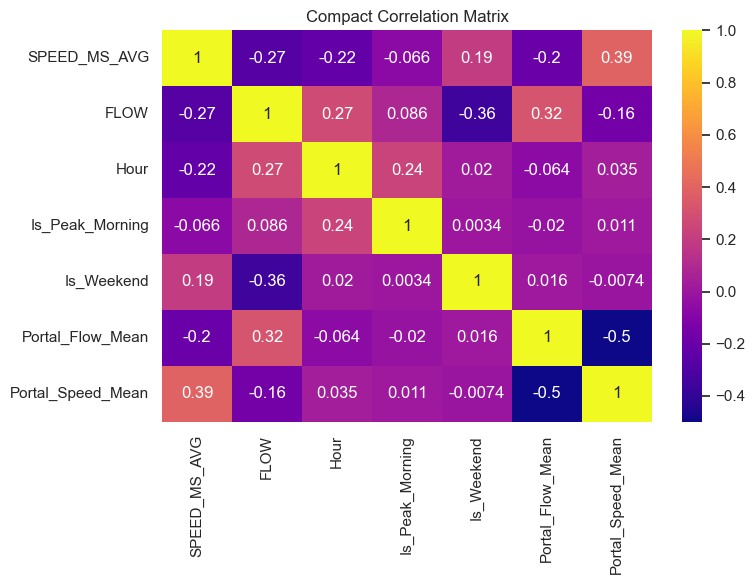

In [8]:
corr_features = [
    'SPEED_MS_AVG',
    'FLOW',
    'Hour',
    'Is_Peak_Morning',
    'Is_Weekend',
    'Portal_Flow_Mean',
    'Portal_Speed_Mean'
]

corr_matrix = model_dataframe[corr_features].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='plasma', square=False)
plt.title('Compact Correlation Matrix')
plt.tight_layout()
plt.show()


## here need to add descriptive analysis

# .....

## 1.4 Feature Cleanup and Scaling

In [9]:
model_ready = model_dataframe.copy()
model_ready = model_ready.drop(columns=['Time', 'PORTAL'], errors='ignore')
print('Columns currently available:', model_ready.columns.tolist())


Columns currently available: ['DP_ID', 'Date', 'Interval_1', 'Interval_5', 'Interval_15', 'Interval_30', 'Interval_60', 'SPEED_MS_AVG', 'FLOW', 'Hour', 'Minute', 'Minute_Of_Day', 'Day_ID', 'Month_ID', 'Is_Weekend', 'Is_Peak_Morning', 'Daily_Sin', 'Daily_Cos', 'Portal_Pos', 'Portal_Flow_Mean', 'Portal_Speed_Mean']


In [10]:
peak_mask = (df_processed['Minute_Of_Day'] >= 7 * 60) & (df_processed['Minute_Of_Day'] <= 8 * 60 + 30)
peak_data = model_ready[peak_mask].copy()

columns_to_remove = ['Date', 'Interval_1', 'Interval_5', 'Interval_15', 'Interval_30', 'Interval_60', 'Minute', 'Minute_Of_Day', 'Daily_Sin', 'Daily_Cos']
peak_data = peak_data.drop(columns=columns_to_remove, errors='ignore')
print('Columns after cleanup:', peak_data.columns.tolist())


Columns after cleanup: ['DP_ID', 'SPEED_MS_AVG', 'FLOW', 'Hour', 'Day_ID', 'Month_ID', 'Is_Weekend', 'Is_Peak_Morning', 'Portal_Pos', 'Portal_Flow_Mean', 'Portal_Speed_Mean']


In [11]:
from sklearn.preprocessing import StandardScaler

feature_columns = [col for col in peak_data.columns if col not in ['FLOW']]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(peak_data[feature_columns])
peak_data_scaled = peak_data.copy()
peak_data_scaled[feature_columns] = scaled_features


In [12]:
print('Peak window rows:', peak_data_scaled.shape[0])
print('Peak window columns:', peak_data_scaled.columns.tolist())
peak_data_scaled.head()


Peak window rows: 515481
Peak window columns: ['DP_ID', 'SPEED_MS_AVG', 'FLOW', 'Hour', 'Day_ID', 'Month_ID', 'Is_Weekend', 'Is_Peak_Morning', 'Portal_Pos', 'Portal_Flow_Mean', 'Portal_Speed_Mean']


,DP_ID,SPEED_MS_AVG,FLOW,Hour,Day_ID,Month_ID,Is_Weekend,Is_Peak_Morning,Portal_Pos,Portal_Flow_Mean,Portal_Speed_Mean
4651,1.258151,-0.648785,9.0,-0.724327,-0.980965,-1.493853,-0.596485,-1.43929,0.0,0.041559,-1.408287
4652,1.258677,-0.744152,5.0,-0.724327,-0.980965,-1.493853,-0.596485,-1.43929,0.0,0.071732,-0.135128
4653,-1.018741,-1.125619,19.0,-0.724327,-0.980965,-1.493853,-0.596485,-1.43929,0.0,0.041559,-1.408287
4654,-1.020845,-0.621538,21.0,-0.724327,-0.980965,-1.493853,-0.596485,-1.43929,0.0,1.098842,0.971155
4655,-1.023475,-0.706687,27.0,-0.724327,-0.980965,-1.493853,-0.596485,-1.43929,0.0,0.041559,-1.408287


## 1.5 Target Construction (15/30/60 Minutes Ahead)

In [13]:
peak_base = df_processed.sort_values(['PORTAL', 'Date', 'Minute_Of_Day']).copy()
future_windows = {15: 'FLOW_NEXT_15', 30: 'FLOW_NEXT_30', 60: 'FLOW_NEXT_60'}
for window, col_name in future_windows.items():
    peak_base[col_name] = peak_base.groupby(['PORTAL', 'Date'])['FLOW']\
        .transform(lambda s: s.rolling(window=window, min_periods=window).sum().shift(-window))

print('Targets created:', list(future_windows.values()))
peak_base[['PORTAL', 'Date', 'Minute_Of_Day', 'FLOW', 'FLOW_NEXT_15']].head()


Targets created: ['FLOW_NEXT_15', 'FLOW_NEXT_30', 'FLOW_NEXT_60']


,PORTAL,Date,Minute_Of_Day,FLOW,FLOW_NEXT_15
17,"E4S 55,620",2021-06-01,240,19.0,140.0
21,"E4S 55,620",2021-06-01,240,4.0,143.0
22,"E4S 55,620",2021-06-01,240,6.0,154.0
24,"E4S 55,620",2021-06-01,241,1.0,173.0
25,"E4S 55,620",2021-06-01,241,12.0,172.0


## 1.6 Lag and Rolling Features for Model Inputs

In [14]:
lag_steps = [1, 5, 10, 15]
for lag in lag_steps:
    peak_base[f'FLOW_LAG_{lag}'] = peak_base.groupby(['PORTAL', 'Date'])['FLOW'].shift(lag)
    peak_base[f'SPEED_LAG_{lag}'] = peak_base.groupby(['PORTAL', 'Date'])['SPEED_MS_AVG'].shift(lag)

rolling_windows = [5, 15]
for window in rolling_windows:
    peak_base[f'FLOW_ROLL_MEAN_{window}'] = peak_base.groupby(['PORTAL', 'Date'])['FLOW']\
        .transform(lambda s: s.shift(1).rolling(window=window, min_periods=1).mean())
    peak_base[f'SPEED_ROLL_MEAN_{window}'] = peak_base.groupby(['PORTAL', 'Date'])['SPEED_MS_AVG']\
        .transform(lambda s: s.shift(1).rolling(window=window, min_periods=1).mean())

columns_to_remove = ['Day', 'Month', 'Time', 'PORTAL']
peak_base = peak_base.drop(columns=[col for col in columns_to_remove if col in peak_base.columns])

peak_window_mask = (peak_base['Minute_Of_Day'] >= 7 * 60) & (peak_base['Minute_Of_Day'] <= 8 * 60 + 30)
model_dataset = peak_base[peak_window_mask].copy()
required_for_supervision = ['FLOW_NEXT_15'] + [f'FLOW_LAG_{lag}' for lag in lag_steps] + [f'SPEED_LAG_{lag}' for lag in lag_steps]
model_dataset = model_dataset.dropna(subset=required_for_supervision)
print('Model dataset shape:', model_dataset.shape)
model_dataset.loc[:, ['FLOW', 'FLOW_NEXT_15'] + [f'FLOW_LAG_{lag}' for lag in lag_steps[:2]]].head()


Model dataset shape: (515082, 36)


,FLOW,FLOW_NEXT_15,FLOW_LAG_1,FLOW_LAG_5
4673,20.0,309.0,19.0,13.0
4677,18.0,308.0,20.0,16.0
4678,21.0,303.0,18.0,21.0
4680,25.0,295.0,21.0,23.0
4681,25.0,294.0,25.0,19.0


In [15]:
# split the data into a training and test set (按时间顺序划分,避免数据泄露)

feature_drop = ['FLOW_NEXT_15', 'FLOW_NEXT_30', 'FLOW_NEXT_60', 'Date']
x = model_dataset.drop(columns=[col for col in feature_drop if col in model_dataset.columns])
y = model_dataset['FLOW_NEXT_15']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
X_train.head()


,DP_ID,Interval_1,Interval_5,Interval_15,Interval_30,Interval_60,SPEED_MS_AVG,FLOW,Hour,Minute,...,FLOW_LAG_5,SPEED_LAG_5,FLOW_LAG_10,SPEED_LAG_10,FLOW_LAG_15,SPEED_LAG_15,FLOW_ROLL_MEAN_5,SPEED_ROLL_MEAN_5,FLOW_ROLL_MEAN_15,SPEED_ROLL_MEAN_15
942080,4427,469,93,31,15,7,22.50,27.0,7,49,...,3.0,17.50,24.0,18.06,27.0,20.56,11.2,19.444,15.400000,19.648667
1049590,4494,503,100,33,16,8,21.67,8.0,8,23,...,3.0,20.83,7.0,19.17,7.0,20.00,4.2,21.666,5.466667,21.851333
575013,4495,503,100,33,16,8,26.67,2.0,8,23,...,2.0,26.94,4.0,15.28,29.0,21.39,5.8,22.666,7.933333,21.666667
490764,4495,486,97,32,16,8,21.67,1.0,8,6,...,4.0,27.22,6.0,20.28,1.0,27.22,4.2,23.054,4.066667,22.703333
736974,543,441,88,29,14,7,18.69,11.0,7,21,...,1.0,23.06,6.0,21.27,16.0,19.41,8.2,20.514,8.333333,20.596667


## XGBoost

In [16]:
# grid search - hyperparameter tuning

from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1, 0.3],
    'max_depth': [3, 4, 5, 6],
    'subsample': [0.6, 0.8, 1.0]
}

grid_search = GridSearchCV(XGBRegressor(objective='reg:squarederror', random_state=3407), param_grid, cv=3, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print('Best Parameters:', best_params)
print('Best Score:', grid_search.best_score_)


Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Parameters: {'learning_rate': 0.3, 'max_depth': 6, 'n_estimators': 300, 'subsample': 1.0}
Best Score: 0.9414495766862646
Best Parameters: {'learning_rate': 0.3, 'max_depth': 6, 'n_estimators': 300, 'subsample': 1.0}
Best Score: 0.9414495766862646


In [23]:
from xgboost import XGBRegressor
# 直接使用已知的最佳参数(跳过耗时的grid search)
best_params = {
    'learning_rate': 0.1,
    'max_depth': 6,
    'n_estimators': 300,
    'subsample': 0.8
}

print('使用预设的最佳参数:')
print(f'  learning_rate: {best_params["learning_rate"]}')
print(f'  max_depth: {best_params["max_depth"]}')
print(f'  n_estimators: {best_params["n_estimators"]}')
print(f'  subsample: {best_params["subsample"]}')

使用预设的最佳参数:
  learning_rate: 0.1
  max_depth: 6
  n_estimators: 300
  subsample: 0.8


In [24]:
# train an XGBoost model

best_xgb = XGBRegressor(
    n_estimators=best_params['n_estimators'],
    learning_rate=best_params['learning_rate'],
    max_depth=best_params['max_depth'],
    subsample=best_params['subsample'],
    objective='reg:squarederror',
    random_state= 3407,
)
best_xgb.fit(X_train, y_train)


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [26]:
# make predictions using the trained model

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred_XG = best_xgb.predict(X_test)

mae_xgb = mean_absolute_error(y_test, y_pred_XG)
mse = mean_squared_error(y_test, y_pred_XG)
rmse_xgb = np.sqrt(mse)
r2_xgb = r2_score(y_test, y_pred_XG)
print(f'Mean Absolute Error: {mae_xgb:.4f}')
print(f'Root Mean Squared Error: {rmse_xgb:.4f}')
print(f'R-squared: {r2_xgb:.4f}')


Mean Absolute Error: 14.4778
Root Mean Squared Error: 18.7827
R-squared: 0.9398


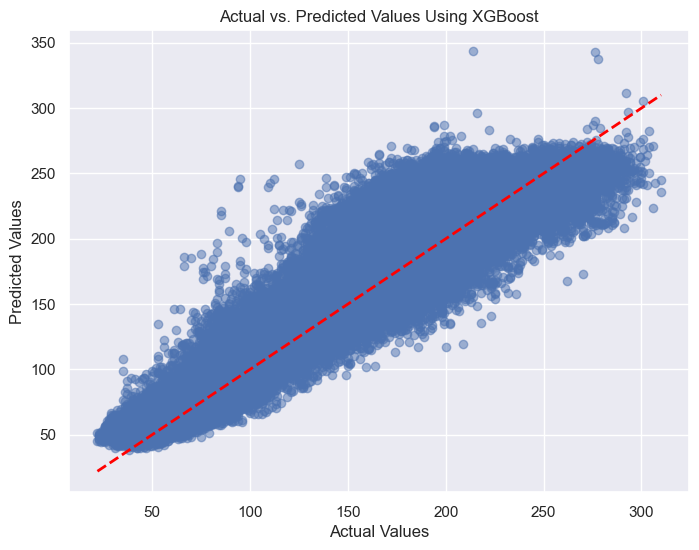

In [39]:
# visualize the predictions

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_XG, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values Using XGBoost')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], linestyle='--', color='red', lw=2)
plt.show()


## 2.2 Linear Regression

In [32]:
from sklearn.linear_model import LinearRegression

LRmodel = LinearRegression()
LRmodel.fit(X_train, y_train)


ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred_LR = LRmodel.predict(X_test)
mae_LR = mean_absolute_error(y_test, y_pred_LR)
mse_LR = mean_squared_error(y_test, y_pred_LR)
rmse_LR = np.sqrt(mse_LR)
r2_LR = r2_score(y_test, y_pred_LR)
print(f'Mean Absolute Error: {mae_LR:.4f}')
print(f'Root Mean Squared Error: {rmse_LR:.4f}')
print(f'R-squared: {r2_LR:.4f}')


Mean Absolute Error: 5.823198623471967
Mean Squared Error: 55.70952905753656
R-squared: 0.9905494728150495


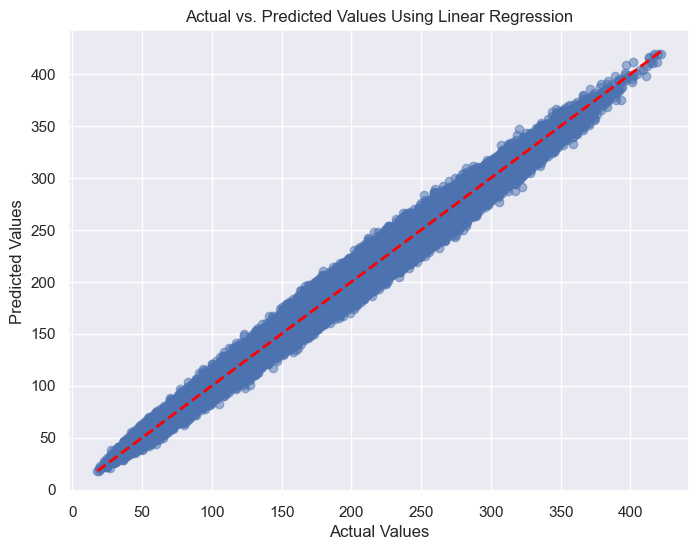

In [18]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_LR, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values Using Linear Regression')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], linestyle='--', color='red', lw=2)
plt.show()


LSTM

In [41]:
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# 排序，确保时间顺序
sort_columns = [col for col in ['Portal_Pos', 'Date', 'Minute_Of_Day'] if col in model_dataset.columns]
lstm_data = model_dataset.sort_values(sort_columns).reset_index(drop=True)

# 目标列与需要排除的列
target_col = 'FLOW_NEXT_15'
drop_cols = ['Date', 'FLOW_NEXT_30', 'FLOW_NEXT_60']

# 生成分钟周期编码（如果可用）
if 'Minute_Of_Day' in lstm_data.columns:
    angle = 2 * np.pi * (lstm_data['Minute_Of_Day'] % 1440) / 1440.0
    lstm_data = lstm_data.copy()
    lstm_data['Minute_Sin'] = np.sin(angle)
    lstm_data['Minute_Cos'] = np.cos(angle)

# LSTM 序列输入采用关键原始信号
seq_cols = [c for c in ['FLOW','SPEED_MS_AVG','Portal_Pos','Minute_Sin','Minute_Cos'] if c in lstm_data.columns]

# 宽特征按工程化前缀自动收集，并补充少量基础列
prefixes = ['FLOW_LAG_','SPEED_LAG_','FLOW_ROLL_MEAN_','SPEED_ROLL_MEAN_']
wide_cols = [c for c in lstm_data.columns if any(c.startswith(p) for p in prefixes)]
for c in ['FLOW','SPEED_MS_AVG','Portal_Pos','Minute_Sin','Minute_Cos']:
    if c in lstm_data.columns and c not in wide_cols:
        wide_cols.append(c)
# 去重保持顺序
wide_cols = list(dict.fromkeys(wide_cols))

# 仅对用到的列做缺失值与标准化
imputer = SimpleImputer(strategy='median')
lstm_data_clean = lstm_data.copy()
if seq_cols:
    lstm_data_clean[seq_cols] = imputer.fit_transform(lstm_data[seq_cols])
if wide_cols:
    lstm_data_clean[wide_cols] = imputer.fit_transform(lstm_data[wide_cols])

scaler_seq = StandardScaler()
feature_values = scaler_seq.fit_transform(lstm_data_clean[seq_cols]) if seq_cols else np.empty((len(lstm_data_clean),0))

scaler_wide = StandardScaler()
wide_values = scaler_wide.fit_transform(lstm_data_clean[wide_cols]) if wide_cols else np.empty((len(lstm_data_clean),0))

# 目标标准化
target_values = lstm_data_clean[target_col].to_numpy().reshape(-1,1)
target_scaler_lstm = StandardScaler()
target_values_scaled = target_scaler_lstm.fit_transform(target_values)

# 窗口长度（短窗更稳）
sequence_length = 16

# 记录列名，便于排查
lstm_feature_columns = seq_cols
wide_feature_columns = wide_cols


In [42]:
X_seq, X_wide_list, y_seq_scaled, y_seq_actual = [], [], [], []

# 分组（如可用）
group_keys = []
if 'Portal_Pos' in lstm_data_clean.columns:
    lstm_data_clean['Portal_Group'] = lstm_data_clean['Portal_Pos'].fillna(-1)
    group_keys.append('Portal_Group')
if 'Date' in lstm_data_clean.columns:
    group_keys.append('Date')

groups_iter = lstm_data_clean.groupby(group_keys, dropna=False) if group_keys else [(None, lstm_data_clean)]

for _, group in groups_iter:
    group_sorted = group.sort_values('Minute_Of_Day') if 'Minute_Of_Day' in group.columns else group
    idxs = group_sorted.index.to_numpy()
    if len(idxs) <= sequence_length:
        continue
    for start in range(len(idxs) - sequence_length):
        window_idx = idxs[start:start + sequence_length]
        target_idx = idxs[start + sequence_length]
        X_seq.append(feature_values[window_idx])
        X_wide_list.append(wide_values[target_idx])
        y_seq_scaled.append(target_values_scaled[target_idx,0])
        y_seq_actual.append(lstm_data_clean[target_col].iloc[target_idx])

X_seq = np.array(X_seq, dtype=np.float32)
X_wide = np.array(X_wide_list, dtype=np.float32)
y_seq_scaled = np.array(y_seq_scaled, dtype=np.float32)
y_seq_actual = np.array(y_seq_actual, dtype=np.float32)

# 去除 NaN 样本
if (np.isnan(X_seq).any() or np.isnan(y_seq_scaled).any() or np.isnan(X_wide).any()):
    valid_indices = ~(np.isnan(X_seq).any(axis=(1,2)) | np.isnan(y_seq_scaled) | np.isnan(X_wide).any(axis=1))
    X_seq = X_seq[valid_indices]
    X_wide = X_wide[valid_indices]
    y_seq_scaled = y_seq_scaled[valid_indices]
    y_seq_actual = y_seq_actual[valid_indices]

# 时间顺序切分
split_index = int(len(X_seq) * 0.8)
X_train_lstm = X_seq[:split_index]
X_test_lstm = X_seq[split_index:]
X_train_wide = X_wide[:split_index]
X_test_wide = X_wide[split_index:]
y_train_scaled_lstm = y_seq_scaled[:split_index]
y_test_scaled_lstm = y_seq_scaled[split_index:]
y_test_actual_lstm = y_seq_actual[split_index:]


In [43]:
import os
import tensorflow as tf

tf.keras.utils.disable_interactive_logging()
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
lstm_device = '/GPU:0' if gpus else '/CPU:0'

l2_reg = tf.keras.regularizers.l2(1e-5)

with tf.device(lstm_device):
    seq_in = tf.keras.layers.Input(shape=(sequence_length, X_train_lstm.shape[-1]), name='seq_input')
    wide_in = tf.keras.layers.Input(shape=(X_train_wide.shape[-1],), name='wide_input')

    # LSTM 残差支路
    x = tf.keras.layers.LayerNormalization()(seq_in)
    x = tf.keras.layers.LSTM(16, dropout=0.1, name='lstm16')(x)
    x = tf.keras.layers.Dense(8, activation='swish', kernel_regularizer=l2_reg)(x)
    residual = tf.keras.layers.Dense(1, name='residual')(x)

    # 宽线性支路（等价线性回归）
    wide_linear = tf.keras.layers.Dense(1, use_bias=True, name='wide_linear')(wide_in)

    y_hat = tf.keras.layers.Add(name='y_hat')([wide_linear, residual])
    lstm_model = tf.keras.Model(inputs=[seq_in, wide_in], outputs=y_hat, name='WideLSTM')
    optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4, clipnorm=1.0)
    lstm_model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

lstm_model_params = lstm_model.count_params()


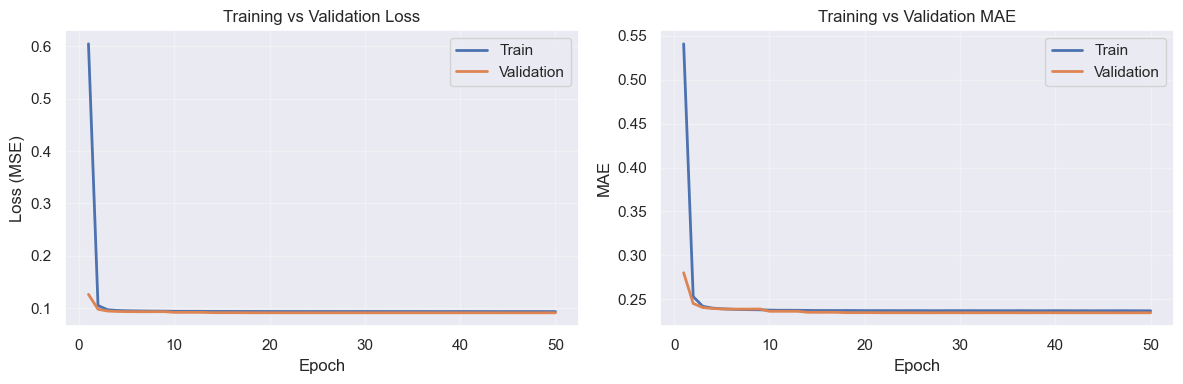

In [44]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=5e-5
)

with tf.device(lstm_device):
    history = lstm_model.fit(
        [X_train_lstm, X_train_wide],
        y_train_scaled_lstm,
        validation_split=0.2,
        epochs=50,
        batch_size=256,
        shuffle=False,
        verbose=2,
        callbacks=[early_stopping, reduce_lr]
    )

history_epochs = range(1, len(history.history['loss']) + 1)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(history_epochs, history.history['loss'], label='Train', linewidth=2)
axes[0].plot(history_epochs, history.history['val_loss'], label='Validation', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (MSE)')
axes[0].set_title('Training vs Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history_epochs, history.history['mae'], label='Train', linewidth=2)
axes[1].plot(history_epochs, history.history['val_mae'], label='Validation', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MAE')
axes[1].set_title('Training vs Validation MAE')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

lstm_training_stats = {
    'epochs_run': len(history.history['loss']),
    'best_epoch': int(np.argmin(history.history['val_loss'])) + 1,
    'best_val_loss': float(np.min(history.history['val_loss'])),
    'final_train_loss': float(history.history['loss'][-1]),
    'final_val_loss': float(history.history['val_loss'][-1])
}


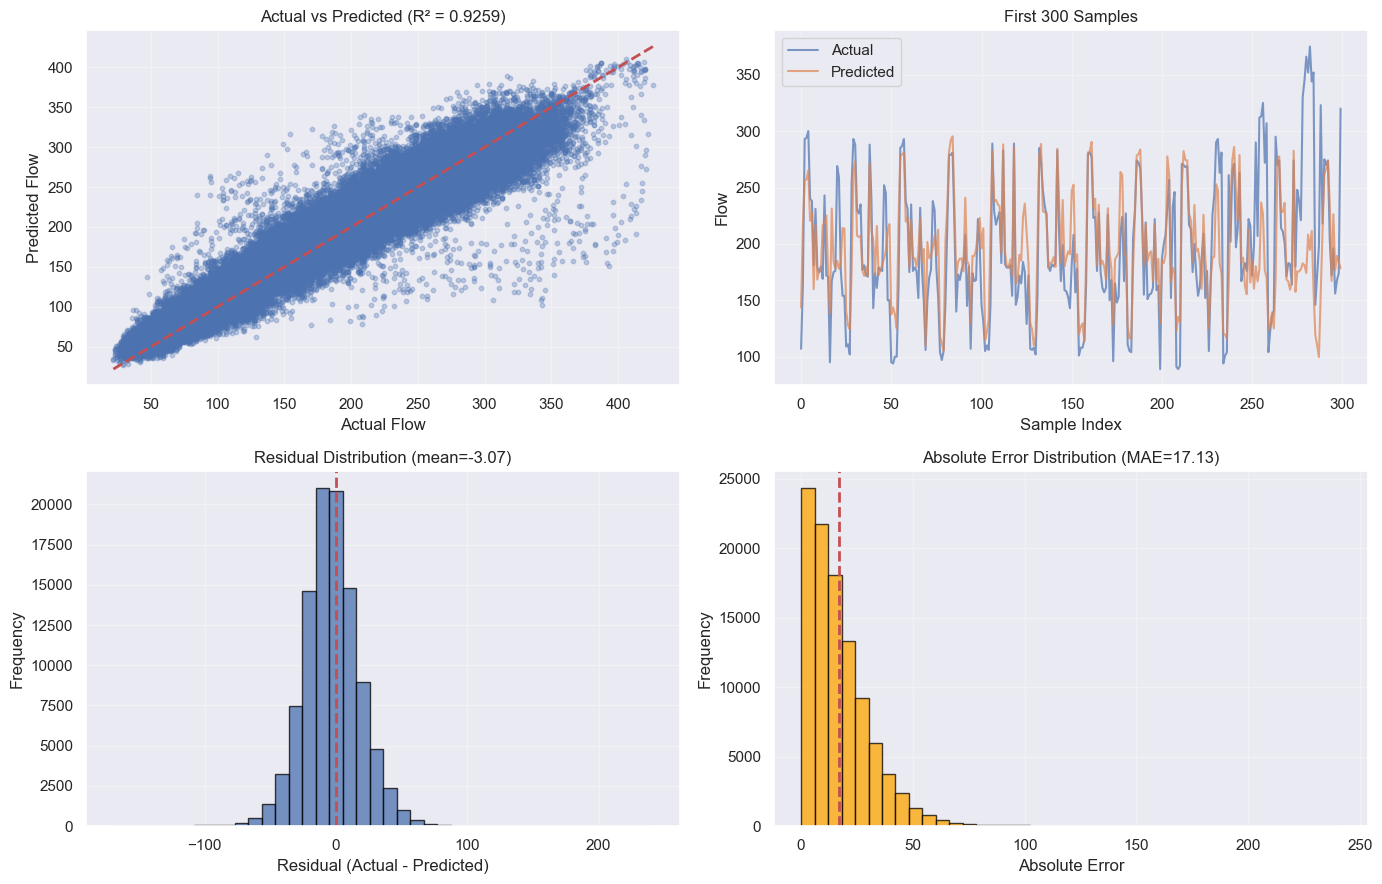

In [45]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

with tf.device(lstm_device):
    y_pred_scaled_lstm = lstm_model.predict([X_test_lstm, X_test_wide], verbose=0)

y_pred_lstm = target_scaler_lstm.inverse_transform(y_pred_scaled_lstm)
y_test_original_lstm = target_scaler_lstm.inverse_transform(y_test_scaled_lstm.reshape(-1, 1))

mae_lstm = mean_absolute_error(y_test_original_lstm, y_pred_lstm)
mse_lstm = mean_squared_error(y_test_original_lstm, y_pred_lstm)
rmse_lstm = float(np.sqrt(mse_lstm))
r2_lstm = r2_score(y_test_original_lstm, y_pred_lstm)

lstm_metrics = {
    'mae': float(mae_lstm),
    'mse': float(mse_lstm),
    'rmse': float(rmse_lstm),
    'r2': float(r2_lstm)
}

residuals = y_test_original_lstm.flatten() - y_pred_lstm.flatten()
abs_errors = np.abs(residuals)

fig, axes = plt.subplots(2, 2, figsize=(14, 9))
axes[0, 0].scatter(y_test_original_lstm, y_pred_lstm, alpha=0.3, s=10)
axes[0, 0].plot([y_test_original_lstm.min(), y_test_original_lstm.max()],
                [y_test_original_lstm.min(), y_test_original_lstm.max()],
                'r--', lw=2)
axes[0, 0].set_xlabel('Actual Flow')
axes[0, 0].set_ylabel('Predicted Flow')
axes[0, 0].set_title(f'Actual vs Predicted (R² = {r2_lstm:.4f})')
axes[0, 0].grid(True, alpha=0.3)

sample_limit = min(300, len(y_test_original_lstm))
axes[0, 1].plot(y_test_original_lstm[:sample_limit], label='Actual', linewidth=1.5, alpha=0.7)
axes[0, 1].plot(y_pred_lstm[:sample_limit], label='Predicted', linewidth=1.5, alpha=0.7)
axes[0, 1].set_xlabel('Sample Index')
axes[0, 1].set_ylabel('Flow')
axes[0, 1].set_title(f'First {sample_limit} Samples')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend()

axes[1, 0].hist(residuals, bins=40, edgecolor='black', alpha=0.75)
axes[1, 0].axvline(0, color='r', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Residual (Actual - Predicted)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title(f'Residual Distribution (mean={residuals.mean():.2f})')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].hist(abs_errors, bins=40, edgecolor='black', alpha=0.75, color='orange')
axes[1, 1].axvline(mae_lstm, color='r', linestyle='--', linewidth=2)
axes[1, 1].set_xlabel('Absolute Error')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title(f'Absolute Error Distribution (MAE={mae_lstm:.2f})')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [46]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print('=== 公平评估校验：特征是否只用过去值 ===')
assert 'model_dataset' in globals(), '未找到 model_dataset，请先执行上游特征工程单元。'

df = model_dataset.copy()
# 推断分组与时间列
portal_col = 'Portal_Pos' if 'Portal_Pos' in df.columns else ('PORTAL' if 'PORTAL' in df.columns else None)
assert portal_col is not None, '未找到 Portal 列（Portal_Pos/PORTAL）'
assert 'Date' in df.columns, '未找到 Date 列'
if 'Minute_Of_Day' not in df.columns and 'Time' in df.columns:
    # 如无 Minute_Of_Day，尝试从 Time 解析
    t = pd.to_datetime(df['Time']).dt
    df['Minute_Of_Day'] = t.hour*60 + t.minute

lag_patterns = [('FLOW_LAG_', 'FLOW'), ('SPEED_LAG_', 'SPEED_MS_AVG')]
roll_patterns = [('FLOW_ROLL_MEAN_', 'FLOW'), ('SPEED_ROLL_MEAN_', 'SPEED_MS_AVG')]

# 检查滞后列
for prefix, base in lag_patterns:
    lag_cols = [c for c in df.columns if c.startswith(prefix)]
    for c in lag_cols:
        try:
            k = int(c.replace(prefix, ''))
        except:
            continue
        def chk(group):
            s = group[base]
            return (group[c] - s.shift(k)).abs()
        delta = df.sort_values(['Date','Minute_Of_Day']).groupby([portal_col,'Date'], dropna=False).apply(chk)
        mismatch_rate = (delta > 1e-6).mean()
        print(f"{c}: 与 {base}.shift({k}) 不一致比例≈ {float(mismatch_rate):.6f}")

# 检查滚动均值列（必须在 shift(1) 之后 rolling）
for prefix, base in roll_patterns:
    roll_cols = [c for c in df.columns if c.startswith(prefix)]
    for c in roll_cols:
        try:
            w = int(c.replace(prefix, ''))
        except:
            continue
        def chk(group):
            s = group[base]
            ref = s.shift(1).rolling(window=w, min_periods=1).mean()
            return (group[c] - ref).abs()
        delta = df.sort_values(['Date','Minute_Of_Day']).groupby([portal_col,'Date'], dropna=False).apply(chk)
        mismatch_rate = (delta > 1e-6).mean()
        print(f"{c}: 与 {base}.shift(1).rolling({w}).mean() 不一致比例≈ {float(mismatch_rate):.6f}")

print('
=== 公平评估校验：时间顺序切分重训 LR/XGB ===')
# 选择特征列（去除目标与明显标签列）
ignore = {'FLOW_NEXT_15','FLOW_NEXT_30','FLOW_NEXT_60'}
num_df = df.select_dtypes(include=[np.number]).copy()
feat_cols = [c for c in num_df.columns if c not in ignore]
assert 'FLOW_NEXT_15' in df.columns, '未找到目标列 FLOW_NEXT_15'
X_all = num_df[feat_cols].to_numpy(dtype=np.float32)
y_all = df['FLOW_NEXT_15'].to_numpy(dtype=np.float32)

# 时间顺序切分
order = df[['Date','Minute_Of_Day']].copy()
order = order.fillna(0)
idx = np.lexsort((order['Minute_Of_Day'].to_numpy(), order['Date'].to_numpy()))
X_all, y_all = X_all[idx], y_all[idx]

split = int(0.8 * len(X_all))
X_train, X_test = X_all[:split], X_all[split:]
y_train, y_test = y_all[:split], y_all[split:]

scaler = StandardScaler().fit(X_train)
X_train_s, X_test_s = scaler.transform(X_train), scaler.transform(X_test)

from sklearn.linear_model import LinearRegression
lr = LinearRegression().fit(X_train_s, y_train)
y_lr = lr.predict(X_test_s)

try:
    from xgboost import XGBRegressor
    xgb = XGBRegressor(n_estimators=200, max_depth=4, learning_rate=0.1,
                       subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=4)
    xgb.fit(X_train, y_train)
    y_xgb = xgb.predict(X_test)
except Exception as e:
    print('XGBoost 不可用，跳过：', e)
    y_xgb = None

for name, pred in [('LR', y_lr), ('XGB', y_xgb)]:
    if pred is None: continue
    mae = mean_absolute_error(y_test, pred)
    mse = mean_squared_error(y_test, pred)
    rmse = mse**0.5
    r2 = r2_score(y_test, pred)
    print(f"{name} -> MAE={mae:.4f} RMSE={rmse:.4f} R²={r2:.4f}")


SyntaxError: unterminated string literal (detected at line 53) (2745848806.py, line 53)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf

print('
=== 全天数据：加载与预处理 ===')
ALLDAY_DIR = 'Final_Project/Dataset/dataset_for_traffic_project_assignment_ALLday'
train_csv = f'{ALLDAY_DIR}/training_dataset.csv'
all_df = pd.read_csv(train_csv, sep=';')
# 解析时间
all_df['Date'] = all_df['Date'].astype(str)
# Time -> 分钟
t = pd.to_datetime(all_df['Time']).dt
all_df['Minute_Of_Day'] = t.hour*60 + t.minute
# 日内周期
angle = 2*np.pi* (all_df['Minute_Of_Day']%1440)/1440.0
all_df['Minute_Sin'] = np.sin(angle)
all_df['Minute_Cos'] = np.cos(angle)
# 门户ID
all_df['Portal_ID'] = all_df['PORTAL'].astype('category').cat.codes

# 目标：FLOW_NEXT_15（组内按时间排序 shift(-15)）
all_df = all_df.sort_values(['PORTAL','Date','Minute_Of_Day'])
all_df['FLOW_NEXT_15'] = all_df.groupby(['PORTAL','Date'], dropna=False)['FLOW'].shift(-15)
# 与目标对齐的分钟（用于早高峰过滤）
all_df['Target_Minute'] = all_df.groupby(['PORTAL','Date'], dropna=False)['Minute_Of_Day'].shift(-15)
all_df = all_df.dropna(subset=['FLOW_NEXT_15'])

# 序列特征（每步）
seq_cols = [c for c in ['FLOW','SPEED_MS_AVG','Portal_ID','Minute_Sin','Minute_Cos'] if c in all_df.columns]

# 缺失填补与标准化
from sklearn.impute import SimpleImputer
imp = SimpleImputer(strategy='median')
all_df[seq_cols] = imp.fit_transform(all_df[seq_cols])

scaler_x = StandardScaler().fit(all_df[seq_cols])
X_all = scaler_x.transform(all_df[seq_cols]).astype(np.float32)
scaler_y = StandardScaler().fit(all_df[['FLOW_NEXT_15']])
y_all = scaler_y.transform(all_df[['FLOW_NEXT_15']]).astype(np.float32).ravel()

seq_len = 16
X_seq, y_seq, tgt_min = [], [], []
for _, g in all_df.groupby(['PORTAL','Date'], dropna=False):
    idxs = g.index.to_numpy()
    vals = X_all[idxs]
    yy = y_all[idxs]
    target_mins = g['Target_Minute'].to_numpy()
    if len(g) <= seq_len: continue
    for s in range(len(g)-seq_len):
        X_seq.append(vals[s:s+seq_len])
        y_seq.append(yy[s+seq_len-1])
        tgt_min.append(target_mins[s+seq_len-1])

X_seq = np.asarray(X_seq, dtype=np.float32)
y_seq = np.asarray(y_seq, dtype=np.float32)
tgt_min = np.asarray(tgt_min, dtype=np.float32)
print('序列样本数:', len(X_seq), '输入形状:', X_seq.shape[1:])

# 基于目标分钟排序切分（近似时间顺序）
order_idx = np.argsort(tgt_min)
split = int(0.8 * len(X_seq))
train_idx, test_idx = order_idx[:split], order_idx[split:]
X_tr, X_te = X_seq[train_idx], X_seq[test_idx]
y_tr, y_te = y_seq[train_idx], y_seq[test_idx]

print('=== 训练纯 LSTM（全天）===')
tf.keras.utils.disable_interactive_logging()
import os; os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

with tf.device('/GPU:0' if tf.config.list_physical_devices('GPU') else '/CPU:0'):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(seq_len, X_tr.shape[-1])),
        tf.keras.layers.LSTM(32, return_sequences=True),
        tf.keras.layers.LayerNormalization(),
        tf.keras.layers.LSTM(16),
        tf.keras.layers.Dense(16, activation='swish'),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(5e-4), loss='mse', metrics=['mae'])

    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
    rlrop = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=5e-5)

    hist = model.fit(X_tr, y_tr, validation_split=0.2, epochs=30, batch_size=256, shuffle=False,
                     callbacks=[es, rlrop], verbose=2)

# 预测并在“早高峰”评估（目标分钟：7:00–8:30）
y_pred_te = model.predict(X_te, verbose=0).ravel()
y_te_inv = scaler_y.inverse_transform(y_te.reshape(-1,1)).ravel()
y_pred_inv = scaler_y.inverse_transform(y_pred_te.reshape(-1,1)).ravel()

peak_mask = (tgt_min[test_idx] >= 7*60) & (tgt_min[test_idx] <= 8*60 + 30)
from math import sqrt
mae = mean_absolute_error(y_te_inv[peak_mask], y_pred_inv[peak_mask])
rmse = sqrt(mean_squared_error(y_te_inv[peak_mask], y_pred_inv[peak_mask]))
r2 = r2_score(y_te_inv[peak_mask], y_pred_inv[peak_mask])
print(f'全天训练，早高峰评估 -> MAE={mae:.4f} RMSE={rmse:.4f} R²={r2:.4f}')
